# Setup

In [47]:
import multiprocessing as mp

from transformers import AutoTokenizer, BertForMaskedLM
import torch
import os
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix

In [48]:
home_path = "../zeste/"

In [49]:
numberbatch = pickle.load(open(home_path+"numberbatch-en-19.08-en.pickle", 'rb'))

In [50]:
def get_word_neighborhood(word, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity(word, ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [51]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [52]:
def get_words_neighborhood(words, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [53]:
mapping = {  'alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

18
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [145]:
for w in get_word_neighborhood('sport', 1):
    if w in numberbatch:
        sim = numberbatch.similarity('sport', w)
        if sim < 0:
            print(w, sim)

porter -0.061320193
pass -0.018902713
friend -0.008180838
long_island -0.07403679
massacre -0.0052293874
miami -0.023918713
divert -0.0021513272
tehran -0.0059437267
oregon -0.01111687
plant -0.03160285
los_angeles -0.055634294
acquaintance -0.008997213
st_louis -0.030364402


In [54]:
ls .

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 cm_20ng.pdf
'GPU1- Pipeline-Alison-classification.ipynb'
'GPU3 - Pipeline-Alison-classification.ipynb'
 hg_Zero_Shot_Pipeline.ipynb
 mono_poly_semcor_experiments_data_en.pkl
 neighborhood20k_20ng_hockey_motorcycle.pickle
 neighborhood20k_20ng_hockey_no_prompt.pickle
 neighborhood20k_20ng_is_about_definition_yahoo.pickle
 neighborhood20k_20ng_is_about_domain_deberta.pickle
 neighborhood20k_20ng_is_about_domain.pickle
 neighborhood20k_20ng_is_about_domain_XLM-RoBERTa-large-XNLI-ANLI.pickle
 neighborhood20k_20ng_is_about_domain_yahoo.pickle
 neighborhood20k_20ng.pickle
 polysemy_bands_semcor_experiments_data.pkl
'ProZe - Pipeline-Alison-classification.ipynb'
'ProZe - Pi

In [55]:
os.path.exists(home_path+'labels_cgr_20ng.pickle')

True

In [56]:
%%time

if os.path.exists(home_path+'labels_cgr_20ng.pickle'):
    labels_cgr = pickle.load(open(home_path+'labels_cgr_20ng.pickle', 'rb'))

else:
    pbar = tqdm(labels)
    labels_cgr = {}
    for label in pbar:
        pbar.set_description(label)
        labels_cgr[label] = get_words_neighborhood(label, 3, 'all', keep='top20000')

CPU times: user 3.14 s, sys: 191 ms, total: 3.33 s
Wall time: 3.32 s


In [57]:
labels_cgr['atheism'].keys()

dict_keys(['atheism', 'panentheism', 'atheistic', 'antiatheistic', 'atheistically', 'deism', 'atheologist', 'panatheism', 'apeirotheism', 'religion', 'atheistical', 'atheisms', 'antiatheist', 'tritheism', 'atheophobia', 'monotheism', 'atheist', 'learning_about_science', 'unbelief', 'agnosticism', 'omnitheism', 'theism', 'adevism', 'atheisticalness', 'deconversion', 'new_atheism', 'ultra_darwinism', 'atheology', 'tetratheism', 'polytheism', "pascal's_wager", 'pantheism', 'belief', 'god', 'secularism', 'atheophobic', 'monolatrism', 'apatheism', 'atheophobe', 'antimetaphysics', 'personal_god', 'impersonal', 'deity', 'anthropomorphized', 'physicalism', 'delusion', 'philosophy', 'metaphysics', 'antimetaphysically', 'antimetaphysical', 'anti_metaphysics', 'ametaphysics', 'positivism', 'materialism', 'antimetaphysicality', 'theophobe', 'religiophobe', 'apathy', 'apatheist', 'apathetic', 'agnostic', 'ignosticism', 'monolatry', 'monolatrous', 'ditheism', 'kathenotheism', 'henotheism', 'monolate

In [58]:
labels_cgr['atheism']['panentheism']['sim']

0.644391

In [59]:
options = {
    'model_name': 'bert-large-uncased-whole-word-masking',#'bert-base-uncased',
    'prompt': {},
}

In [60]:
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']

['atheism',
 'baseball',
 'car',
 'christianity',
 'cryptography',
 'electronics',
 'graphic',
 'gun',
 'hardware',
 'hockey',
 'medicine',
 'middle_east',
 'motorcycle',
 'politics',
 'religion',
 'sale',
 'space',
 'windows']

In [61]:
options['prompt']['atheism'] = 'Atheism is an absence of belief in the existence of God.'
options['prompt']['baseball'] = 'Baseball is a bat-and-ball game played between two opposing teams, typically of nine players each, that take turns batting and fielding.'
options['prompt']['car'] = 'A car or automobile is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one-to-eight people, have four wheels and mainly transport people rather than goods.'
options['prompt']['christianity'] = 'Christianity is an Abrahamic, monotheistic religion based on the life and teachings of Jesus of Nazareth. It is the world\'s largest religion.'
options['prompt']['cryptography'] = 'Cryptography or cryptology is the practice and study of techniques for secure communication in the presence of adversarial behavior.'
options['prompt']['electronics'] = 'Electronics comprises the physics, engineering, technology and applications that deal with the emission, flow and control of electrons in vacuum and matter.'
options['prompt']['graphic'] = 'Graphics are visual images or designs on some surface, such as a wall, canvas, screen, paper, or stone to inform, illustrate, or entertain. It includes a pictorial representation of data, as in design and manufacture, in typesetting and the graphic arts, and in educational and recreational software.'
options['prompt']['gun'] = 'A gun is a ranged weapon designed to use a shooting tube (gun barrel) to launch typically solid projectiles'
options['prompt']['hardware'] = 'Computer hardware includes the physical parts of a computer, such as the case, central processing unit (CPU), monitor, mouse, keyboard, computer data storage, graphics card, sound card, speakers and motherboard.'
options['prompt']['hockey'] = 'Hockey is a sport in which two teams play against each other by trying to manoeuvre a ball or a puck into the opponent\'s goal using a hockey stick'
options['prompt']['medicine'] = 'Medicine is the science and practice of caring for a patient, managing the diagnosis, prognosis, prevention, treatment, palliation of their injury or disease, and promoting their health.'
options['prompt']['middle_east'] = 'The Middle East is a geopolitical term that commonly refers to the region spanning the Levant, Arabian Peninsula, Anatolia (including modern Turkey and Cyprus), Egypt, Iran and Iraq.'
options['prompt']['motorcycle'] = 'A motorcycle, often called a motorbike, bike, or cycle, is a two- or three-wheeled motor vehicle.'
options['prompt']['politics'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'
options['prompt']['religion'] = 'Religion is a social-cultural system of designated behaviors and practices, morals, beliefs, worldviews, texts, sanctified places, prophecies, ethics, or organizations, that relates humanity to supernatural, transcendental, and spiritual elements.'
options['prompt']['sale'] = 'Sales are activities related to selling or the number of goods sold in a given targeted time period. The delivery of a service for a cost is also considered a sale.'
options['prompt']['space'] = 'Outer space is the expanse that exists beyond Earth and between celestial bodies.'
options['prompt']['windows'] = 'Windows is a group of several proprietary graphical operating system families, all of which are developed and marketed by Microsoft. Each family caters to a certain sector of the computing industry.'

## Filter with the LM

In [62]:
tokenizer = AutoTokenizer.from_pretrained(options['model_name'])
bert = BertForMaskedLM.from_pretrained(options['model_name'])

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
bert_vocab = tokenizer.get_vocab()
reverse_vocab = {i:w for w,i in bert_vocab.items()}
len(bert_vocab)

30522

In [64]:
labels_mapping = {'atheism':'Atheism', 
                  'baseball':'Baseball', 
                  'car': 'A car', 
                  'christianity': 'Christianity', 
                  'cryptography': 'Cryptography', 
                  'electronics': 'Electronics', 
                  'graphic': 'Graphics', 
                  'gun': 'A gun', 
                  'hardware': 'Hardware', 
                  'hockey': 'Hockey', 
                  'medicine': 'Medicine', 
                  'middle_east': 'The Middle East', 
                  'motorcycle': 'A motorcycle', 
                  'politics': 'Politics', 
                  'religion': 'Religion', 
                  'sale': 'A sale', 
                  'space': 'Space', 
                  'windows': 'Windows'
}

In [65]:
%time
candidates_scores = {}

# options['prompt'] = 'an opening in the wall or roof of a building or vehicle that is fitted with glass or other transparent material in a frame to admit light or air and allow people to see out.'

for label in options['prompt']:
    template = f"{options['prompt'][label]} [SEP] {labels_mapping[label]} is related to {tokenizer.mask_token}."
    tokens_idx = tokenizer.encode(template)
    print(tokens_idx)

    # print(template, len(template))
    tokens = tokenizer.convert_ids_to_tokens(tokens_idx)

    # print(tokens, len(tokens))

    scores = bert(torch.tensor([tokens_idx]))[0][0][-3].detach().numpy()
    
    candidates_scores[label] = sorted([(reverse_vocab[i], s) for i,s in enumerate(scores)], key=lambda c: -c[1])

    # print(logits.shape)
    print(label, '   ', candidates_scores[label][:20])

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 13.6 µs
[101, 2012, 26036, 6491, 2003, 2019, 6438, 1997, 6772, 1999, 1996, 4598, 1997, 2643, 1012, 102, 2012, 26036, 6491, 2003, 3141, 2000, 103, 1012, 102]
atheism     [('skepticism', 19.465067), ('religion', 19.3738), ('christianity', 18.795042), ('faith', 16.613783), ('judaism', 16.496681), ('buddhism', 16.24447), ('ethics', 16.040823), ('atheist', 15.949947), ('theology', 15.92915), ('philosophy', 15.835138), ('disbelief', 15.583164), ('realism', 15.438873), ('liberalism', 15.360762), ('spirituality', 15.329241), ('hinduism', 15.142475), ('reason', 14.995586), ('denial', 14.654554), ('orthodoxy', 14.387155), ('ignorance', 14.078326), ('criticism', 13.962098)]
[101, 3598, 2003, 1037, 7151, 1011, 1998, 1011, 3608, 2208, 2209, 2090, 2048, 10078, 2780, 1010, 4050, 1997, 3157, 2867, 2169, 1010, 2008, 2202, 4332, 9640, 1998, 15452, 1012, 102, 3598, 2003, 3141, 2000, 103, 1012, 102]
baseball     [('softball', 19.377165), ('cricket', 

motorcycle     [('bicycles', 20.404259), ('bicycle', 17.133087), ('automobiles', 16.931593), ('atv', 15.298226), ('motorcycles', 14.810185), ('cycles', 14.330965), ('cars', 13.721285), ('aircraft', 13.1059), ('jeep', 13.029472), ('bikes', 13.014017), ('motorcycle', 12.867299), ('vehicles', 12.768101), ('touring', 12.444929), ('automobile', 12.396436), ('trucks', 12.3320465), ('carts', 12.083364), ('transport', 12.007777), ('racing', 11.993438), ('trams', 11.933544), ('hybrids', 11.715053)]
[101, 4331, 2003, 1996, 2275, 1997, 3450, 2008, 2024, 3378, 2007, 2437, 6567, 1999, 2967, 1010, 2030, 2060, 3596, 1997, 2373, 4262, 2090, 3633, 1010, 2107, 2004, 1996, 4353, 1997, 4219, 2030, 3570, 1012, 102, 4331, 2003, 3141, 2000, 103, 1012, 102]
politics     [('economics', 16.349415), ('philosophy', 13.956636), ('government', 13.570746), ('sociology', 13.140476), ('religion', 13.102334), ('governance', 13.065233), ('law', 12.979392), ('history', 12.715471), ('diplomacy', 12.6391535), ('geography',

In [66]:
labels_cgr.keys()

dict_keys(['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows'])

In [67]:
neighborhood = {}
for label in tqdm(labels_cgr):
    neighborhood[label] = {}
    dd = dict(candidates_scores[label][:20000])
    for word in labels_cgr[label]:
        if word in dd:
            neighborhood[label][word] = (labels_cgr[label][word]['sim'], dd[word])

  0%|          | 0/18 [00:00<?, ?it/s]

In [68]:
for label in neighborhood:
    total = max([x[1] for x in neighborhood[label].values()])
    for word in neighborhood[label]:
        neighborhood[label][word] = (neighborhood[label][word][0], neighborhood[label][word][1]/total)

In [69]:
sorted([(k, d['sim']) for k, d in labels_cgr['baseball'].items()], key=lambda x: -x[1])

[('baseball', 1.0),
 ('charging_mound', 0.9978942),
 ('baseballing', 0.9978942),
 ('ghost_runner', 0.9840192),
 ('batting_coach', 0.9769366),
 ('pitching_coach', 0.9769366),
 ('hit_ball_squarely', 0.973795),
 ('three_hitter', 0.9703248),
 ('one_hitter', 0.9699128),
 ('four_hitter', 0.9696816),
 ('five_hitter', 0.96914554),
 ('push_bunt', 0.95842916),
 ('two_hitter', 0.9554656),
 ('dead_red', 0.9502086),
 ('setup_man', 0.94866115),
 ('push_bunts', 0.9470002),
 ('no_hit_game', 0.94420666),
 ('can_of_corn', 0.9398043),
 ('circuit_slugger', 0.9397104),
 ('ptbnl', 0.9387398),
 ('strike_out_looking', 0.9378957),
 ('hidden_ball_trick', 0.9359189),
 ('baseball_coach', 0.93579566),
 ('pitcher_mound', 0.9351494),
 ('warning_track', 0.93427753),
 ('perfect_game', 0.9333116),
 ('league_championship_series', 0.93128854),
 ('up_to_bat', 0.9298937),
 ('played_on', 0.92968506),
 ('dying_quail', 0.92889315),
 ('baseballese', 0.923704),
 ('seeing_eye_ball', 0.92314374),
 ('rough_up_bullpen', 0.92079604)

In [70]:
sorted(neighborhood['atheism'].items(), key=lambda x: -x[1][0])

[('atheist', (0.8464324, 0.81941396)),
 ('religion', (0.60271966, 0.99531126)),
 ('christianity', (0.5708972, 0.9655781)),
 ('catholicism', (0.48626375, 0.6015745)),
 ('theology', (0.4597925, 0.8183455)),
 ('belief', (0.45718902, 0.69737995)),
 ('religions', (0.45357776, 0.69366306)),
 ('secular', (0.44758087, 0.5822171)),
 ('unitarian', (0.4409743, 0.42626503)),
 ('orthodoxy', (0.42977548, 0.7391269)),
 ('religious', (0.4145326, 0.5296761)),
 ('beliefs', (0.41429132, 0.61602056)),
 ('faith', (0.4067817, 0.8535179)),
 ('humanist', (0.40587962, 0.58120936)),
 ('philosophical', (0.401689, 0.37799)),
 ('theological', (0.40044212, 0.26315734)),
 ('heresy', (0.3989464, 0.6141192)),
 ('believer', (0.3929792, 0.2915243)),
 ('spirituality', (0.38641468, 0.7875257)),
 ('doctrine', (0.3832467, 0.5175862)),
 ('evangelical', (0.38211563, 0.43539706)),
 ('god', (0.37906212, 0.7002177)),
 ('protestant', (0.37833798, 0.32211795)),
 ('christian', (0.37475446, 0.4839068)),
 ('believers', (0.37455803, 0

In [71]:
sorted(neighborhood['atheism'].items(), key=lambda x: -x[1][1])

[('skepticism', (0.37020683, 1.0)),
 ('religion', (0.60271966, 0.99531126)),
 ('christianity', (0.5708972, 0.9655781)),
 ('faith', (0.4067817, 0.8535179)),
 ('judaism', (0.34036237, 0.8475019)),
 ('buddhism', (0.33356208, 0.83454484)),
 ('ethics', (0.21844172, 0.8240826)),
 ('atheist', (0.8464324, 0.81941396)),
 ('theology', (0.4597925, 0.8183455)),
 ('philosophy', (0.371479, 0.8135157)),
 ('disbelief', (0.31284916, 0.8005708)),
 ('realism', (0.20724207, 0.793158)),
 ('liberalism', (0.36998254, 0.78914505)),
 ('spirituality', (0.38641468, 0.7875257)),
 ('hinduism', (0.36196423, 0.7779308)),
 ('reason', (0.14417869, 0.77038455)),
 ('denial', (0.24928895, 0.7528643)),
 ('orthodoxy', (0.42977548, 0.7391269)),
 ('ignorance', (0.1611622, 0.7232611)),
 ('criticism', (0.12227753, 0.71729004)),
 ('socialism', (0.22394101, 0.71448994)),
 ('science', (0.24867299, 0.706422)),
 ('god', (0.37906212, 0.7002177)),
 ('belief', (0.45718902, 0.69737995)),
 ('democracy', (0.14053988, 0.69455534)),
 ('evo

In [72]:
sorted(neighborhood['christianity'].items(), key=lambda x: -x[1][1])

[('judaism', (0.5123797, 1.0)),
 ('islam', (0.5137478, 0.8167131)),
 ('buddhism', (0.43170995, 0.7029379)),
 ('christianity', (1.0, 0.6829313)),
 ('hinduism', (0.4312008, 0.68002313)),
 ('abraham', (0.1174188, 0.6287446)),
 ('jews', (0.2859522, 0.62184465)),
 ('judas', (0.32212737, 0.6180871)),
 ('religion', (0.6771525, 0.61200476)),
 ('catholicism', (0.76989305, 0.5893582)),
 ('antiquity', (0.2531711, 0.5547476)),
 ('jewish', (0.23329699, 0.55103457)),
 ('muslims', (0.37755808, 0.544574)),
 ('philosophy', (0.24087206, 0.533402)),
 ('orthodoxy', (0.6213301, 0.51591825)),
 ('torah', (0.21718337, 0.5140196)),
 ('plato', (0.1346288, 0.51347315)),
 ('prophecy', (0.17424168, 0.51254433)),
 ('mythology', (0.1778244, 0.5120934)),
 ('faith', (0.50595814, 0.4976693)),
 ('jesus', (0.59427595, 0.4914163)),
 ('religions', (0.5994966, 0.4892564)),
 ('angels', (0.14934263, 0.48821557)),
 ('evolution', (0.1362945, 0.4878405)),
 ('scripture', (0.4775228, 0.48694217)),
 ('baptism', (0.4640532, 0.485730

In [73]:
for label in neighborhood:
    print(label, ':', len(neighborhood[label]))

atheism : 1211
baseball : 1269
car : 1027
christianity : 1004
cryptography : 654
electronics : 661
graphic : 962
gun : 944
hardware : 811
hockey : 1218
medicine : 213
middle_east : 839
motorcycle : 1145
politics : 957
religion : 731
sale : 1379
space : 937
windows : 1149


In [74]:
print("""WITH TOP3000:
=============
atheism : 658
baseball : 487
car : 569
christianity : 539
cryptography : 426
electronics : 376
graphic : 506
gun : 535
hardware : 538
hockey : 592
medicine : 160
middle_east : 576
motorcycle : 661
politics : 560
religion : 470
sale : 640
space : 451
windows : 513
""")

WITH TOP3000:
atheism : 658
baseball : 487
car : 569
christianity : 539
cryptography : 426
electronics : 376
graphic : 506
gun : 535
hardware : 538
hockey : 592
medicine : 160
middle_east : 576
motorcycle : 661
politics : 560
religion : 470
sale : 640
space : 451
windows : 513



# Evaluation

In [75]:
ds_20ng = pd.read_csv(home_path+'datasets/20ng_preprocessed_dataset.csv')
ds_20ng.head()

Unnamed: 0                  label  \
0           0              rec.autos   
1           1  comp.sys.mac.hardware   
2           2  comp.sys.mac.hardware   
3           3          comp.graphics   
4           4              sci.space   

                                                text  
0  car wondering anyone could enlighten car saw d...  
1  clock poll final call summary final call clock...  
2  question well folk mac plus finally gave ghost...  
3  weitek robert kyanko wrote writes far low leve...  
4  shuttle launch question error wondering expect...

In [76]:
for x in ds_20ng[ds_20ng.label == 'soc.religion.christian'].text.head(5):
    print(x)

pantheism environmentalism doe anybody see current emphasis environment turned unintentionally course pantheism yes adamantly environmentalist styrofoam table service please keep mind read post wish attack environmentalism half truth least dangerous complete lie complete lie rarely readily accepted half truth lie subtly hidden powerfully offered masquerade angel light satan people loosened grip treating earth something god intricate handiwork something health future generation based treated respect think going happily leave error rejected style push people opposite error therefore earth god intricate handiwork rubbish god mother earth primarily love serve see two facet response care environment treat proper respect god intricate handiwork health future generation showing facet disregardful thing doe constitute apostle paul called becoming thing men possible mean might save say forget environment got important thing spend time putting foot mouth manner destroy credibility expressing thi

In [77]:
mapping = {  'alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

18
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [78]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            if 'sim' in label_neighborhood[token]:
                similarity = label_neighborhood[token]['sim']
            else:
                similarity = label_neighborhood[token][0] * label_neighborhood[token][1] 
            if similarity > 0:
                # related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [79]:
def scoring_document(doc, labels=labels_cgr):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def generate_predictions(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document, corpus_preprocessed)
    return predictions

def scoring_document_pro(doc, labels=neighborhood):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def generate_predictions_pro(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document_pro, corpus_preprocessed)
    return predictions

In [80]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [81]:
%%time
pool = mp.Pool(mp.cpu_count())
data_20ng = pool.map(preprocess, ds_20ng.text)
pool.close()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [82]:
get_document_score(data_20ng[0], neighborhood['car'])

5.1054253447800875

In [83]:
%%time
predictions = generate_predictions(data_20ng)
print(len(predictions))
prediction_labels = [labels[p] for p in predictions]
true_labels = [mapping[l] for l in ds_20ng.label.tolist()]

print(classification_report(prediction_labels, true_labels, digits=3))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

<AxesSubplot:>

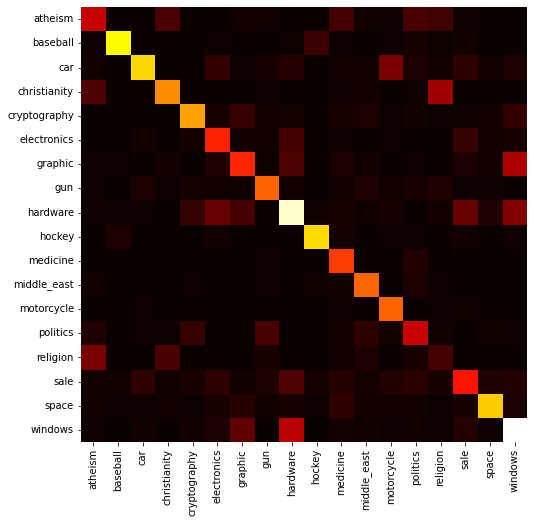

In [84]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, cmap='hot', cbar=False)

In [85]:
print("""With3000
precision    recall  f1-score   support

     atheism      0.315     0.364     0.337       415
    baseball      0.709     0.883     0.786       479
         car      0.800     0.501     0.616       949
christianity      0.629     0.590     0.609       639
cryptography      0.504     0.637     0.563       471
 electronics      0.337     0.684     0.451       291
     graphic      0.438     0.480     0.458       533
         gun      0.672     0.678     0.675       541
    hardware      0.539     0.454     0.493      1389
      hockey      0.863     0.761     0.809       681
    medicine      0.544     0.871     0.669       371
 middle_east      0.637     0.775     0.699       463
  motorcycle      0.584     0.893     0.706       391
    politics      0.411     0.389     0.400       491
    religion      0.241     0.192     0.214       473
        sale      0.542     0.364     0.436       870
       space      0.772     0.648     0.705       707
     windows      0.612     0.625     0.619      1160

    accuracy                          0.575     11314
   macro avg      0.564     0.599     0.569     11314
weighted avg      0.589     0.575     0.572     11314

CPU times: user 642 ms, sys: 2.34 s, total: 2.99 s
Wall time: 3.75 s
""")

With3000
precision    recall  f1-score   support

     atheism      0.315     0.364     0.337       415
    baseball      0.709     0.883     0.786       479
         car      0.800     0.501     0.616       949
christianity      0.629     0.590     0.609       639
cryptography      0.504     0.637     0.563       471
 electronics      0.337     0.684     0.451       291
     graphic      0.438     0.480     0.458       533
         gun      0.672     0.678     0.675       541
    hardware      0.539     0.454     0.493      1389
      hockey      0.863     0.761     0.809       681
    medicine      0.544     0.871     0.669       371
 middle_east      0.637     0.775     0.699       463
  motorcycle      0.584     0.893     0.706       391
    politics      0.411     0.389     0.400       491
    religion      0.241     0.192     0.214       473
        sale      0.542     0.364     0.436       870
       space      0.772     0.648     0.705       707
     windows      0.612     0.62

In [86]:
print('''WITH 6000:
precision    recall  f1-score   support

     atheism      0.325     0.355     0.339       439
    baseball      0.831     0.869     0.849       571
         car      0.813     0.508     0.625       951
christianity      0.656     0.594     0.623       662
cryptography      0.652     0.676     0.664       574
 electronics      0.357     0.653     0.462       323
     graphic      0.491     0.425     0.456       676
         gun      0.645     0.689     0.666       511
    hardware      0.518     0.500     0.509      1209
      hockey      0.832     0.839     0.835       595
    medicine      0.534     0.873     0.662       363
 middle_east      0.676     0.812     0.738       469
  motorcycle      0.569     0.912     0.700       373
    politics      0.409     0.410     0.409       463
    religion      0.204     0.194     0.199       396
        sale      0.540     0.362     0.433       874
       space      0.799     0.650     0.717       729
     windows      0.596     0.621     0.609      1136

    accuracy                          0.590     11314
   macro avg      0.580     0.608     0.583     11314
weighted avg      0.603     0.590     0.587     11314

CPU times: user 737 ms, sys: 2.41 s, total: 3.15 s
Wall time: 4.06 s
''')

WITH 6000:
precision    recall  f1-score   support

     atheism      0.325     0.355     0.339       439
    baseball      0.831     0.869     0.849       571
         car      0.813     0.508     0.625       951
christianity      0.656     0.594     0.623       662
cryptography      0.652     0.676     0.664       574
 electronics      0.357     0.653     0.462       323
     graphic      0.491     0.425     0.456       676
         gun      0.645     0.689     0.666       511
    hardware      0.518     0.500     0.509      1209
      hockey      0.832     0.839     0.835       595
    medicine      0.534     0.873     0.662       363
 middle_east      0.676     0.812     0.738       469
  motorcycle      0.569     0.912     0.700       373
    politics      0.409     0.410     0.409       463
    religion      0.204     0.194     0.199       396
        sale      0.540     0.362     0.433       874
       space      0.799     0.650     0.717       729
     windows      0.596     0.

In [87]:
print(""" 20000 Top words
precision    recall  f1-score   support

     atheism      0.352     0.367     0.360       460
    baseball      0.883     0.830     0.856       635
         car      0.827     0.523     0.641       939
christianity      0.688     0.589     0.635       699
cryptography      0.634     0.689     0.660       547
 electronics      0.418     0.632     0.503       391
     graphic      0.500     0.420     0.457       695
         gun      0.634     0.678     0.655       510
    hardware      0.478     0.513     0.495      1087
      hockey      0.823     0.856     0.839       577
    medicine      0.508     0.893     0.648       338
 middle_east      0.651     0.836     0.732       439
  motorcycle      0.565     0.918     0.700       368
    politics      0.452     0.420     0.435       500
    religion      0.170     0.187     0.178       342
        sale      0.549     0.370     0.442       867
       space      0.820     0.633     0.714       768
     windows      0.590     0.606     0.598      1152

    accuracy                          0.592     11314
   macro avg      0.586     0.609     0.586     11314
weighted avg      0.609     0.592     0.591     11314
""")

 20000 Top words
precision    recall  f1-score   support

     atheism      0.352     0.367     0.360       460
    baseball      0.883     0.830     0.856       635
         car      0.827     0.523     0.641       939
christianity      0.688     0.589     0.635       699
cryptography      0.634     0.689     0.660       547
 electronics      0.418     0.632     0.503       391
     graphic      0.500     0.420     0.457       695
         gun      0.634     0.678     0.655       510
    hardware      0.478     0.513     0.495      1087
      hockey      0.823     0.856     0.839       577
    medicine      0.508     0.893     0.648       338
 middle_east      0.651     0.836     0.732       439
  motorcycle      0.565     0.918     0.700       368
    politics      0.452     0.420     0.435       500
    religion      0.170     0.187     0.178       342
        sale      0.549     0.370     0.442       867
       space      0.820     0.633     0.714       768
     windows      0.590 

In [88]:
print("""With 6000 + summing the two scores
              precision    recall  f1-score   support

     atheism      0.504     0.218     0.305      1108
    baseball      0.670     0.697     0.683       574
         car      0.631     0.548     0.587       684
christianity      0.102     0.314     0.154       194
cryptography      0.539     0.510     0.524       630
 electronics      0.205     0.548     0.298       221
     graphic      0.408     0.357     0.381       666
         gun      0.518     0.618     0.564       458
    hardware      0.557     0.365     0.441      1783
      hockey      0.617     0.853     0.716       434
    medicine      0.478     0.845     0.611       336
 middle_east      0.500     0.758     0.603       372
  motorcycle      0.644     0.773     0.703       498
    politics      0.477     0.280     0.353       792
    religion      0.170     0.172     0.171       372
        sale      0.458     0.315     0.373       852
       space      0.664     0.535     0.593       736
     windows      0.233     0.457     0.309       604

    accuracy                          0.463     11314
   macro avg      0.465     0.509     0.465     11314
weighted avg      0.502     0.463     0.462     11314

CPU times: user 706 ms, sys: 2.45 s, total: 3.16 s
Wall time: 4.17 s
""")

With 6000 + summing the two scores
              precision    recall  f1-score   support

     atheism      0.504     0.218     0.305      1108
    baseball      0.670     0.697     0.683       574
         car      0.631     0.548     0.587       684
christianity      0.102     0.314     0.154       194
cryptography      0.539     0.510     0.524       630
 electronics      0.205     0.548     0.298       221
     graphic      0.408     0.357     0.381       666
         gun      0.518     0.618     0.564       458
    hardware      0.557     0.365     0.441      1783
      hockey      0.617     0.853     0.716       434
    medicine      0.478     0.845     0.611       336
 middle_east      0.500     0.758     0.603       372
  motorcycle      0.644     0.773     0.703       498
    politics      0.477     0.280     0.353       792
    religion      0.170     0.172     0.171       372
        sale      0.458     0.315     0.373       852
       space      0.664     0.535     0.593   

In [89]:
print("""With 6000 + With just BERT score
precision    recall  f1-score   support

     atheism      0.512     0.213     0.301      1154
    baseball      0.640     0.674     0.656       567
         car      0.604     0.546     0.573       658
christianity      0.077     0.253     0.118       182
cryptography      0.523     0.491     0.507       633
 electronics      0.195     0.528     0.284       218
     graphic      0.397     0.349     0.371       665
         gun      0.502     0.602     0.547       455
    hardware      0.557     0.356     0.434      1827
      hockey      0.577     0.832     0.681       416
    medicine      0.470     0.840     0.603       332
 middle_east      0.496     0.755     0.599       371
  motorcycle      0.649     0.759     0.700       511
    politics      0.473     0.277     0.349       795
    religion      0.156     0.162     0.159       364
        sale      0.439     0.299     0.356       860
       space      0.658     0.522     0.582       747
     windows      0.195     0.413     0.265       559

    accuracy                          0.448     11314
   macro avg      0.451     0.493     0.449     11314
weighted avg      0.492     0.448     0.449     11314
""")

With 6000 + With just BERT score
precision    recall  f1-score   support

     atheism      0.512     0.213     0.301      1154
    baseball      0.640     0.674     0.656       567
         car      0.604     0.546     0.573       658
christianity      0.077     0.253     0.118       182
cryptography      0.523     0.491     0.507       633
 electronics      0.195     0.528     0.284       218
     graphic      0.397     0.349     0.371       665
         gun      0.502     0.602     0.547       455
    hardware      0.557     0.356     0.434      1827
      hockey      0.577     0.832     0.681       416
    medicine      0.470     0.840     0.603       332
 middle_east      0.496     0.755     0.599       371
  motorcycle      0.649     0.759     0.700       511
    politics      0.473     0.277     0.349       795
    religion      0.156     0.162     0.159       364
        sale      0.439     0.299     0.356       860
       space      0.658     0.522     0.582       747
     win

In [90]:
%%time
predictions2 = generate_predictions_pro(data_20ng)
prediction_labels2 = [labels[p] for p in predictions2]
true_labels = [mapping[l] for l in ds_20ng.label.tolist()]

print(classification_report(prediction_labels2, true_labels, digits=3))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

<AxesSubplot:>

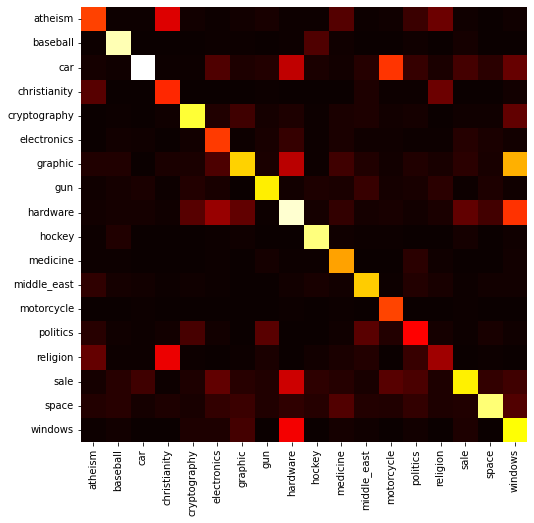

In [91]:
cm2 = confusion_matrix(prediction_labels2, true_labels)
cm2_df = pd.DataFrame(cm2, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm2_df, cmap='hot', cbar=False)